# iX-Artikel "Kurvendiskussion"

von Stefanie Scholz und Christian Winkler

## Voraussetzungen

Achtung, das Notebook ist alleine nicht direkt ablauffähig. Wir dürfen die Reddit-Daten leider nicht mitliefern.

Daher sind folgende Schritte notwendig:
* Script `00-01-download.py` aufrufen (am besten auf dem eigenen Computer, in Google Colab evtl. auch möglich, aber es läuft sehr lang)
  * Das Script lädt die List der URLs herunter, falls sie noch nicht existiert
  * Für jede URL wird das entsprechende JSON-File heruntergeladen, wenn es noch nicht existiert
  * Auf diese Weise kann das Skript neu gestartet werden, wenn es abbricht
  * Abhängig von der Internet-Anbindung kann das Skript sehr, sehr lange laufen

* Script `00-02-insert.py` aufrufen
  * Zunächst wird eine SQLite-Datenbank angelegt
  * Anschließend werden alle Kommentare eingelesen
  * Die Kommentare werden analysiert
  * Die Kommentare werden in der Datenbank gespeichert
  * Schließlich wird ein View erzeugt
  * Das Skript läuft etwa zehn Minuten
  
Als Ergebnis steht dann eine SQLite-Datenbank zur Verfügung, in der alle Posts und Kommentare gespeichert sind. Diese dient als Basis für die Analyse. 

Da einige Kommentare gesperrt wurden, neue hinzugekommen sind usw. können sich leicht andere Ergebnisse als im Artikel ergeben.

## Imports und Vorbereitung

In [1]:
import pandas as pd
import sqlite3

In [2]:
sql = sqlite3.connect("reddit.db")

## Scores der Autoren

<AxesSubplot:ylabel='author'>

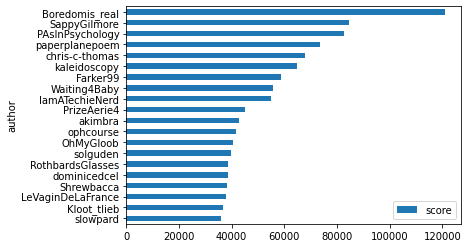

In [8]:
pd.read_sql("SELECT author, AVG(score) AS score FROM posts2020 \
    GROUP BY author \
    ORDER BY score DESC LIMIT 20", sql).\
    set_index("author")[::-1].plot.barh()

<AxesSubplot:ylabel='author'>

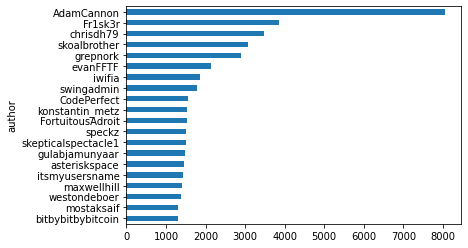

In [6]:
pd.read_sql("SELECT author, AVG(score) AS score, COUNT(*) AS count \
    FROM posts2020 \
    GROUP BY author HAVING count>100\
    ORDER BY score DESC LIMIT 20", sql).\
    set_index("author")["score"][::-1].plot.barh()

<AxesSubplot:ylabel='author'>

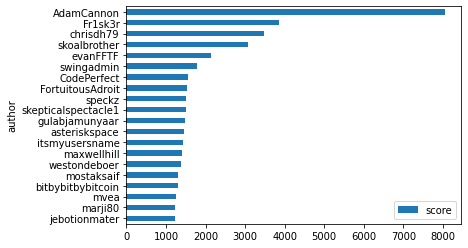

In [7]:
pd.read_sql("SELECT author, AVG(score) AS score FROM posts2020 \
    WHERE author IN \
    (SELECT author FROM \
    (SELECT author, COUNT(*) AS count FROM posts2020 \
    WHERE parent_id IS NULL \
    GROUP BY author HAVING count>100)) \
    GROUP BY author \
    ORDER BY score DESC LIMIT 20", sql).\
    set_index("author")[::-1].plot.barh()

## Posting-Verhalten von Autoren

In [9]:
# Anzahl der Autoren
pd.read_sql("SELECT COUNT(DISTINCT author) FROM posts2020", sql)

,COUNT(DISTINCT author)
0,1074297


In [10]:
# Anzahl der Autoren von Initialposts
pd.read_sql("SELECT COUNT(DISTINCT author) FROM posts2020 WHERE parent_id IS NULL", sql)

,COUNT(DISTINCT author)
0,455458


In [12]:
# Anzahl der Autoren, die nur Initialposts verfasst haben
pd.read_sql("SELECT COUNT(DISTINCT author) FROM posts2020 WHERE parent_id IS NULL AND author NOT IN \
              (SELECT DISTINCT author FROM posts2020 WHERE parent_id IS NOT NULL)", sql)

,COUNT(DISTINCT author)
0,352854


In [13]:
# Anzahl der Autoren von Kommentaren
pd.read_sql("SELECT COUNT(DISTINCT author) FROM posts2020 WHERE parent_id IS NOT NULL", sql)

,COUNT(DISTINCT author)
0,721443


In [14]:
# Anzahl der Autoren, die nur Kommentare verfasst haben
pd.read_sql("SELECT COUNT(DISTINCT author) FROM posts2020 WHERE parent_id IS NOT NULL AND author NOT IN \
   (SELECT DISTINCT author FROM posts2020 WHERE parent_id IS NULL)", sql)

,COUNT(DISTINCT author)
0,618839


In [15]:
# Anzahl der Autoren, die Initialposts und Kommentare verfasst haben
pd.read_sql("SELECT COUNT(DISTINCT author) FROM posts2020 WHERE parent_id IS NOT NULL AND author IN \
                 (SELECT DISTINCT author FROM posts2020 WHERE parent_id IS NULL)", sql)

,COUNT(DISTINCT author)
0,102604


## Graph-Metriken

In [16]:
# Autoren mit mehr als 20 Posts
pd.read_sql("SELECT author, COUNT(*) AS count \
                FROM posts2020 GROUP BY author \
                HAVING count>20", sql)

,author,count
0,*polhold00268,29
1,---------_----_---_,44
2,------__------------,33
3,-----BroAway-----,32
4,----0----,29
...,...,...
51341,zzatz,27
51342,zzita,34
51343,zzoom,36
51344,zztraider,22


<AxesSubplot:ylabel='author'>

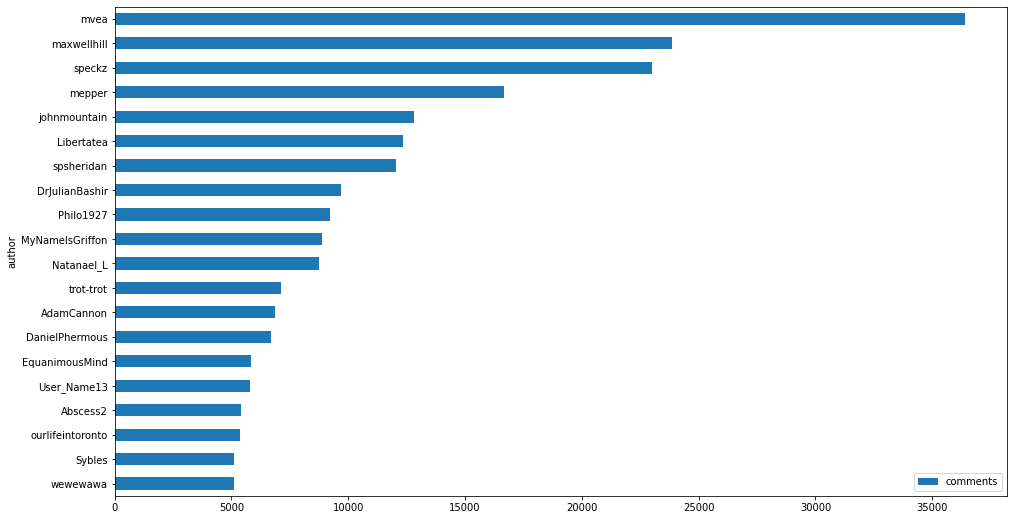

In [17]:
# erhaltene Kommentare (In-Degree)
cpa = pd.read_sql("SELECT p.author, COUNT(*) AS comments \
                   FROM posts2020 p, posts2020 c\
                   WHERE c.parent_id=p.id AND\
                   p.author NOT IN ('[deleted]', 'AutoModerator', 'WikiTextBot', 'HelperBot_') AND \
                   c.author NOT IN ('AutoModerator', 'WikiTextBot', 'HelperBot_') \
                   GROUP BY p.author ORDER BY comments DESC LIMIT 20", sql)
cpa.set_index("author")[::-1].plot.barh(figsize=(16,9))

<AxesSubplot:ylabel='author'>

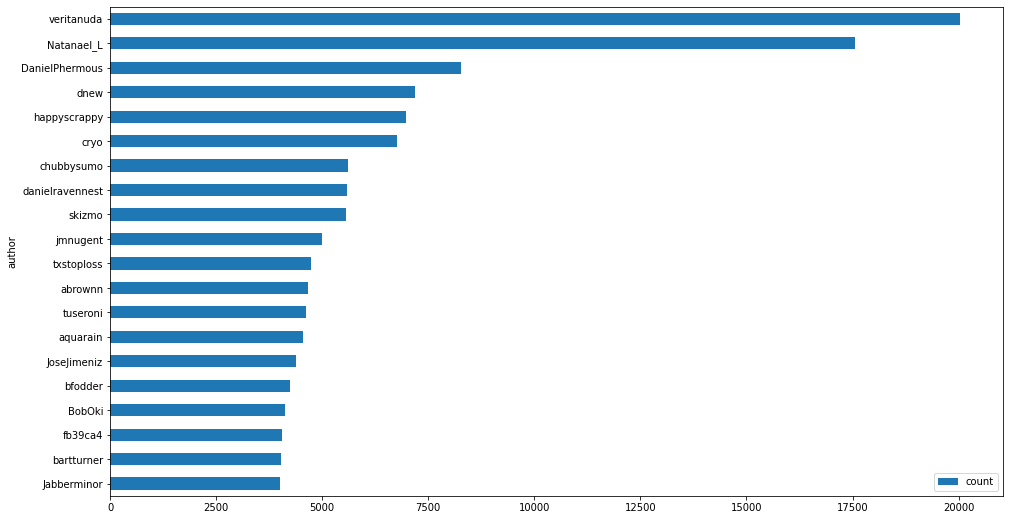

In [18]:
# gegebene Kommentare (Out-Degree)
cga = pd.read_sql("SELECT author, COUNT(*) AS count \
                   FROM posts2020 \
                   WHERE parent_id IS NOT NULL AND \
                   author NOT IN ('[deleted]', 'AutoModerator', 'WikiTextBot', 'HelperBot_') \
                   GROUP BY author \
                   ORDER BY count DESC LIMIT 20", sql)
cga.set_index("author")[::-1].plot.barh(figsize=(16,9))

<AxesSubplot:ylabel='author'>

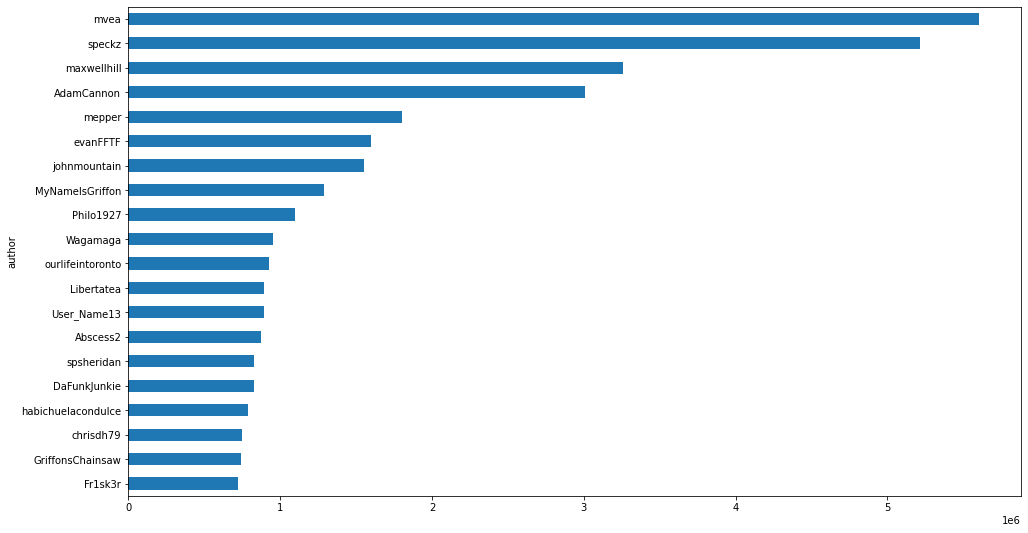

In [19]:
# lokales Karma
local_karma = pd.read_sql("select author, sum(score) as score, count(*) as count \
                           from posts \
                           where author NOT IN ('[deleted]', 'AutoModerator', 'WikiTextBot', 'HelperBot_') \
                           group by author \
                           order by score desc limit 20", sql)
local_karma.set_index("author")["score"][::-1].plot.barh(figsize=(16,9))

## Graph aufbauen

In [25]:
ar = pd.read_sql("with linear as \
                    (select parent_id, \
                        group_concat(author) as response_authors, \
                        group_concat(created_utc) as timestamps, \
                        group_concat(score) as score \
                        from posts2020 group by parent_id) \
                    select p.author as parent_author, response_authors \
                        from posts2020 p, linear l \
                        where p.id=l.parent_id", sql)

In [48]:
top_authors = pd.read_sql("SELECT author FROM \
                              (SELECT author, COUNT(*) AS count FROM posts2020 \
                                   WHERE author NOT IN ('[deleted]', 'AutoModerator', 'WikiTextBot', 'HelperBot_') \
                                   GROUP BY author HAVING count>1000)", sql)["author"].values

In [49]:
len(top_authors)

304

In [50]:
from collections import Counter
from tqdm.auto import tqdm
edges = Counter()
for i, a in tqdm(ar.iterrows(), total=len(ar)):
    target = a["parent_author"]
    if target in top_authors:
        for source in a["response_authors"].split(","):
            if source in top_authors:
                edges["#".join([source, target])] += 1

  0%|          | 0/3674443 [00:00<?, ?it/s]

In [27]:
import sys
sys.path.append("/usr/lib/python3/dist-packages/")

In [28]:
from graph_tool.all import *

In [38]:
g = Graph()
node_names = g.new_vertex_property("string")

In [51]:
import numpy as np
nodes = {}
node_number = {}
for i, n in enumerate(np.unique([node for edge in edges for node in edge.split("#")])):
    nodes[n] = g.add_vertex()
    node_names[nodes[n]] = n
    node_number[i] = n
    g.vertex_properties["name"] = node_names

In [52]:
# make name property internal
g.vertex_properties["name"] = node_names

In [53]:
edge_weights = g.new_edge_property("int")
edge_width = g.new_edge_property("double")

In [54]:
max_weight = edges.most_common(1)[0][1]
for edge in edges:
    (source, target) = edge.split("#")
    e = g.add_edge(nodes[source], nodes[target])
    edge_weights[e] = edges[edge]
    edge_width[e] = 5*edges[edge]/max_weight

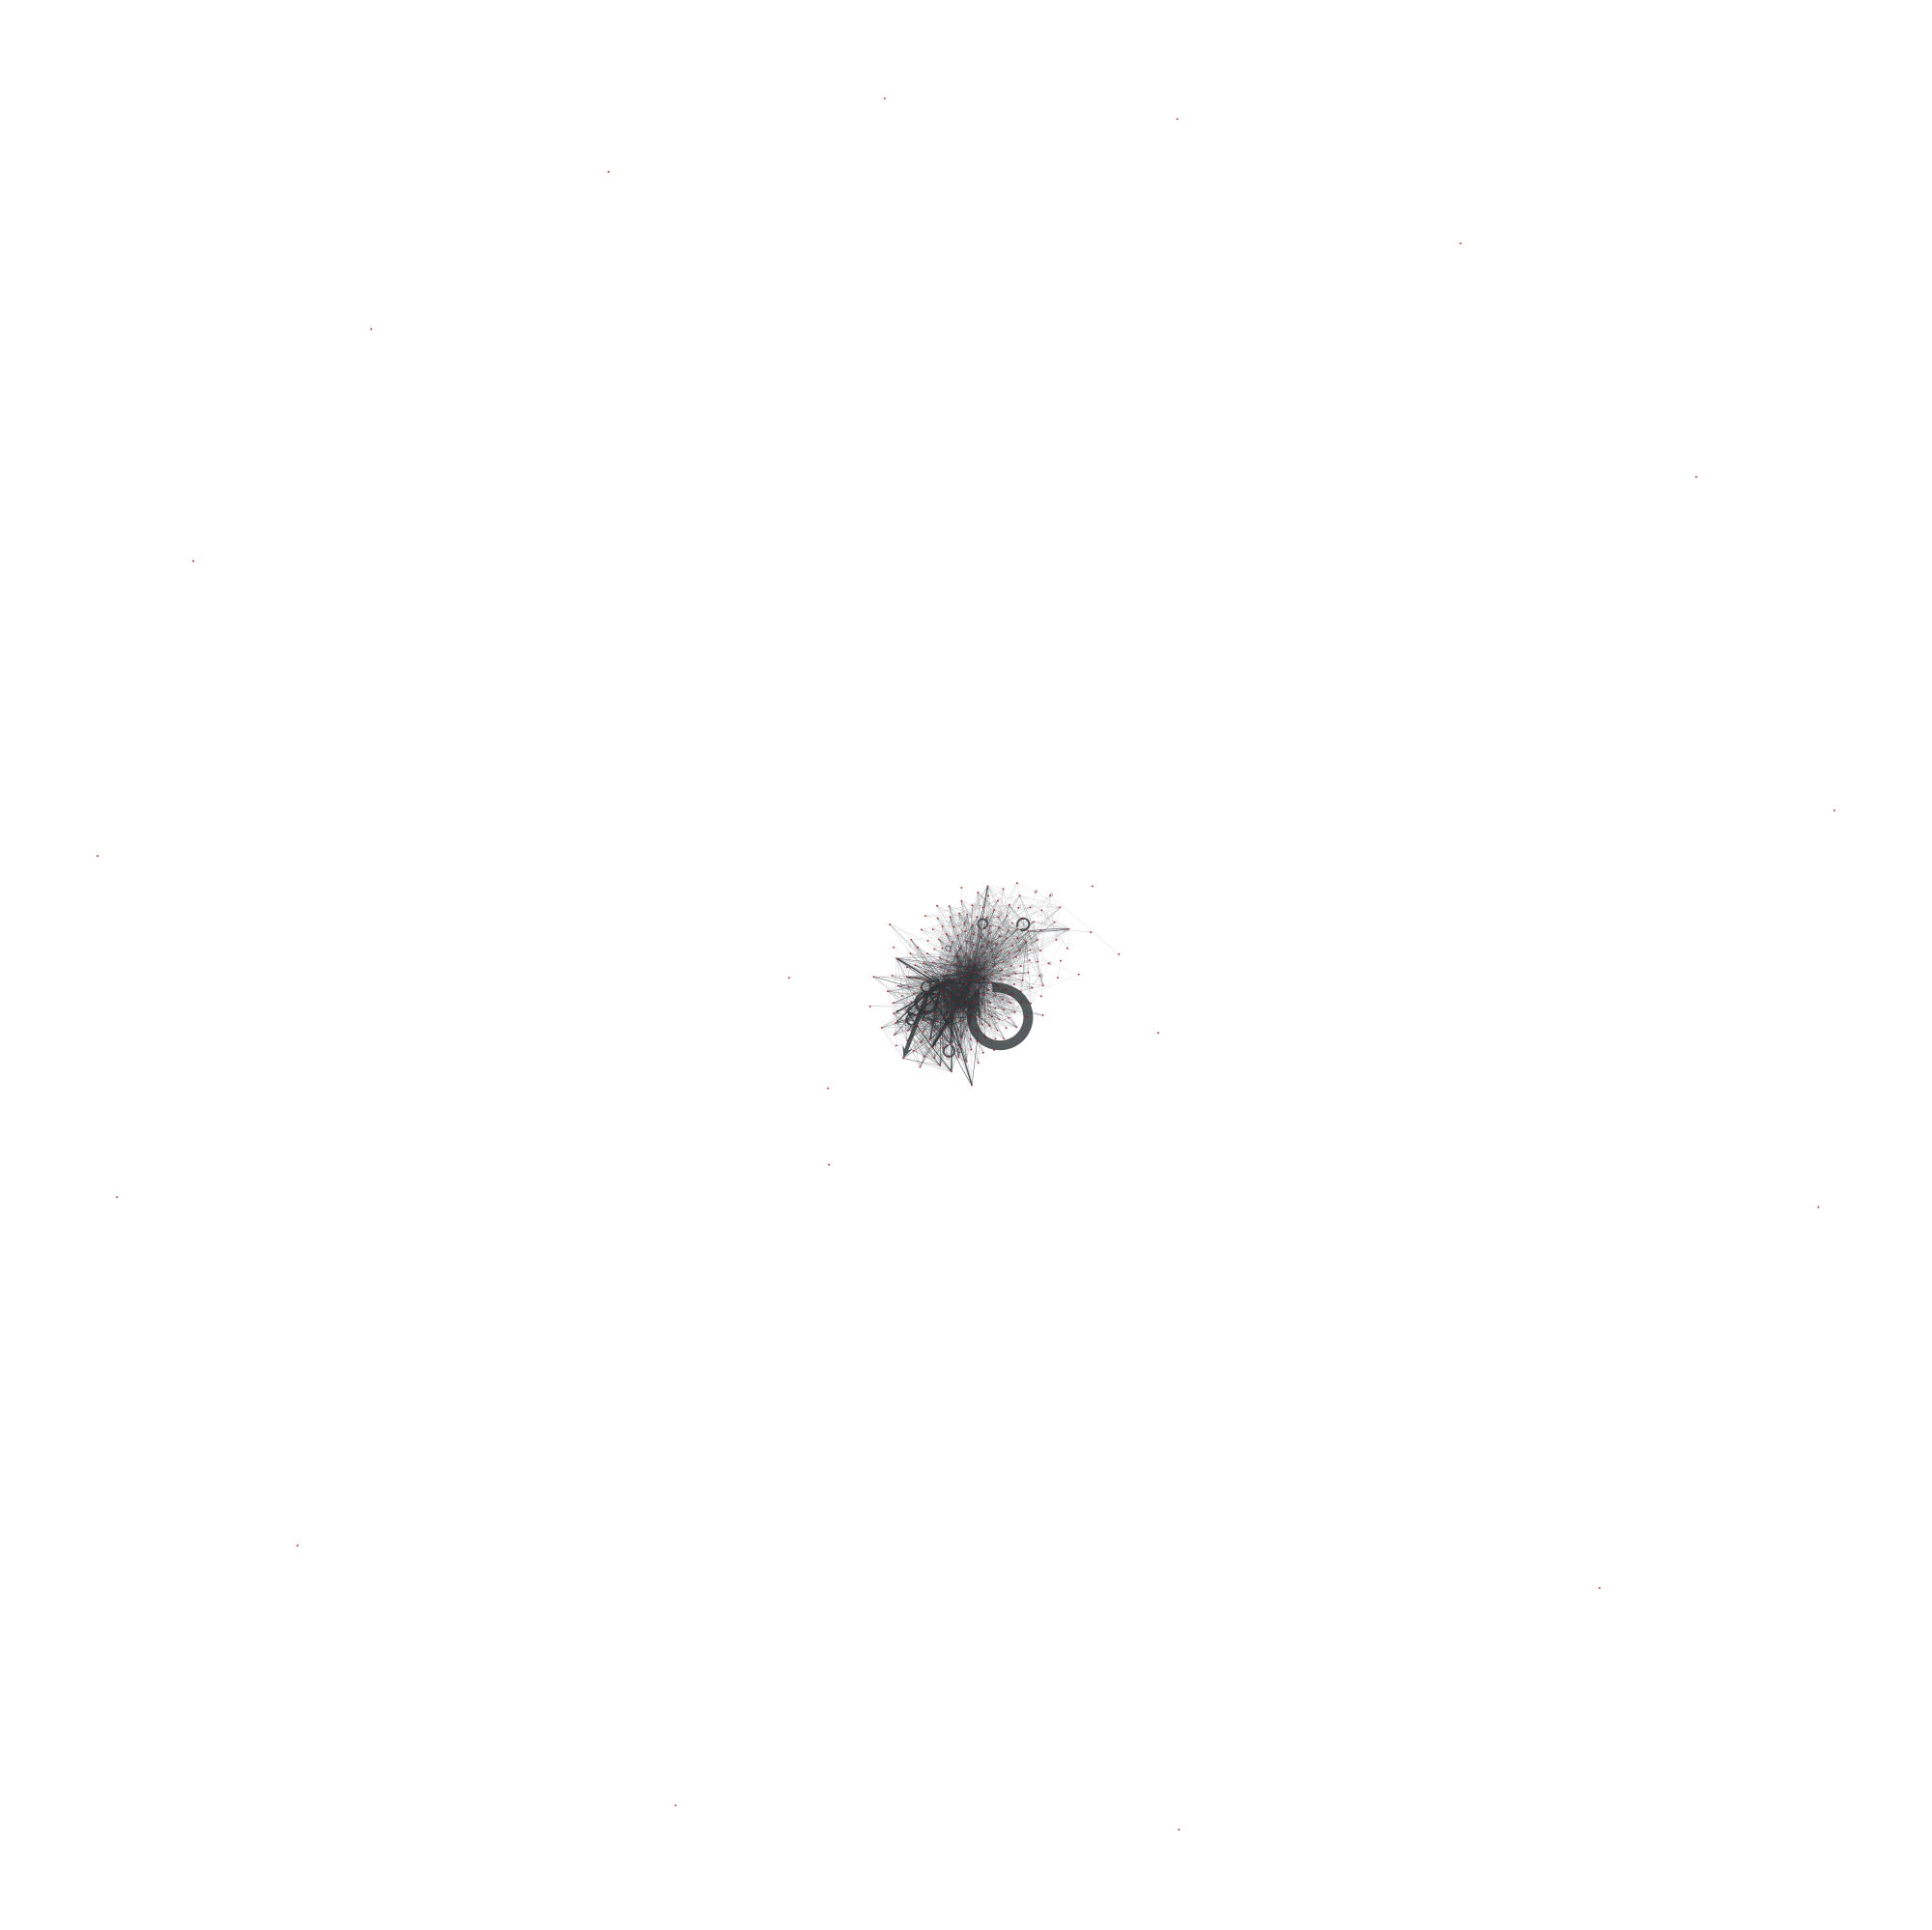

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ffa08f2ea30, at 0x7ffa08d18700>

In [55]:
import matplotlib
pos = sfdp_layout(g)
graph_draw(g, pos, output_size=(1000, 1000), vertex_color=[1,1,1,0],
           vertex_size=1, edge_pen_width=edge_width, # 0.2
           vcmap=matplotlib.cm.gist_heat_r)

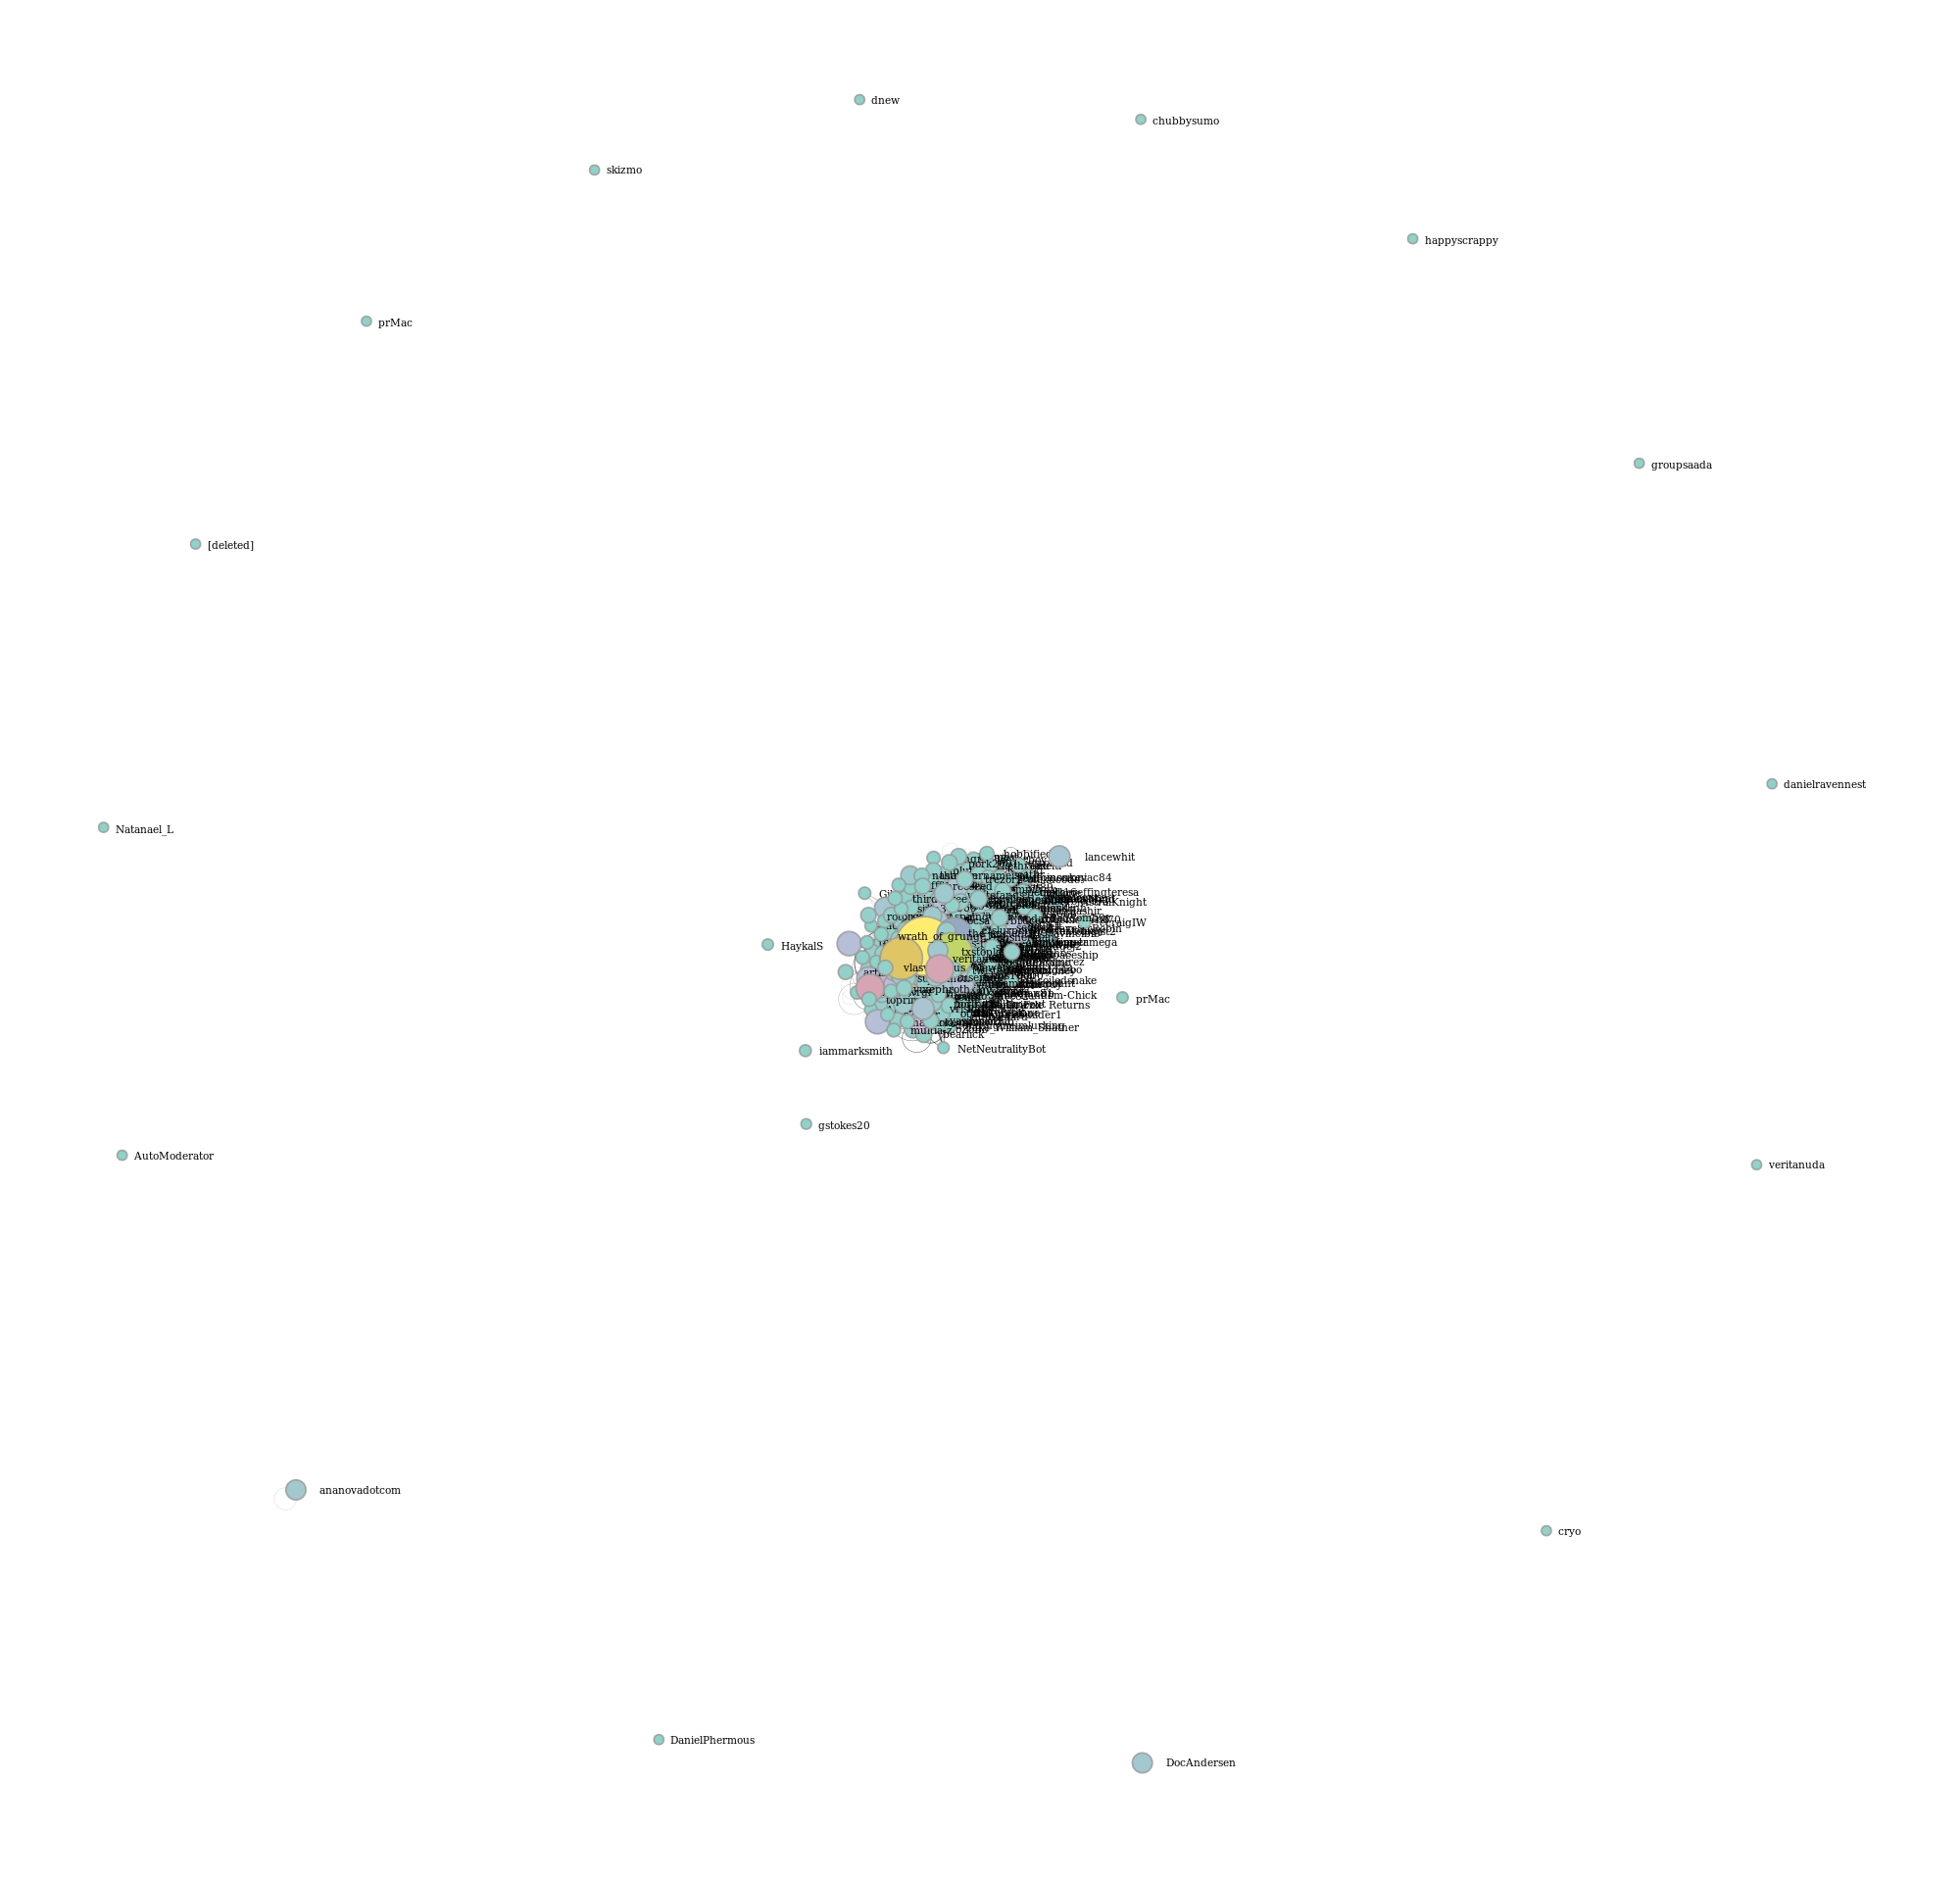

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ffa08f2ea30, at 0x7ffa08bd6e80>

In [56]:
g.set_edge_filter(None)
pr = pagerank(g, weight=edge_weights)
graph_draw(g, pos, output_size=(1000, 1000), vertex_fill_color=pr, 
           edge_pen_width=edge_width, #0.2, 
           vertex_text=node_names, vertex_text_position=0.0,
           vertex_size=prop_to_size(pr, mi=5, ma=30))


<AxesSubplot:ylabel='author'>

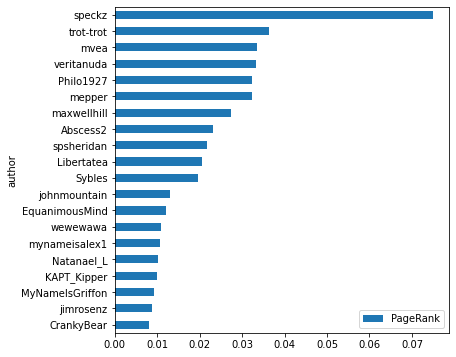

In [57]:
res = []
for i in np.argsort(list(pr))[-20:]:
    res.append({"author": node_names[g.vertex(i)], "PageRank": pr[i]})
pd.DataFrame(res).set_index("author").plot.barh(figsize=(6, 6))